#Importing of libraries

Importing of the relevant libraries that will be utilized for the CNN architecture and evaluation methods.

In [ ]:
from sklearn import svm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
# obtain data
from torchvision import datasets, transforms
import numpy as np

# The MNIST Dataset

## Loading and displaying the MNIST dataset
The following transformations, in addition to converting the images to tensors, are applied to the MNIST dataset when it is loaded from the PyTorch libraries:

1.  Vertical Flip with a probability of 0.5
2.  Gaussian blur with a kernel size of 5

The dataset is then split into a train, validation and test datasets which are used to train and evaluate the model.


Finally, a random sample of the images are displayed with the transformations applied.



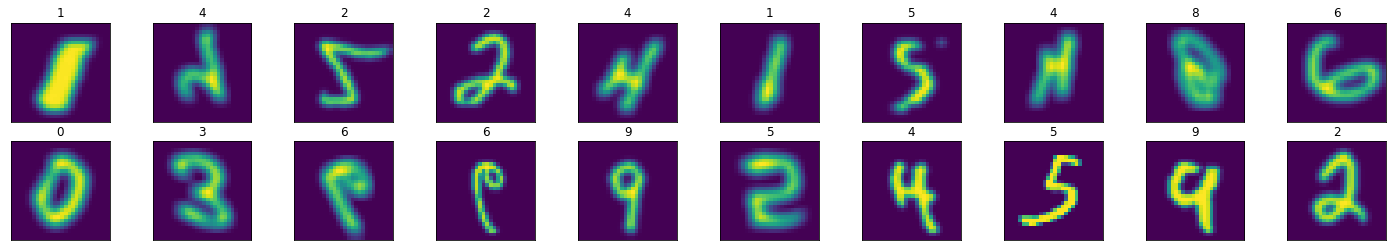

In [ ]:
#load and print data
torch.manual_seed(1) # set the random seed

# Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

transform = transforms.Compose([transforms.GaussianBlur(kernel_size=5),
                                transforms.RandomVerticalFlip(), 
                                transforms.ToTensor()])
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transform)
mnist_data = list(mnist_data)
mnist_train = mnist_data[:10000]
mnist_val   = mnist_data[10000:12000]
mnist_test = mnist_data[12000:14000]

batch_size = 27
num_workers = 1
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)

classes = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

def img_convert(tensor):
  image = tensor
  if image.shape[2] == 1:
      image = image[:, :, 0]
  return image

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(np.transpose(images[idx], (1, 2, 0))))
  ax.set_title(classes[labels[idx]])

## The MNIST CNN Model
The code block below is the architecture of the CNN used for the MNIST dataset. It consists of an _init_ method with the various layers of the CNN along with a _forward_ method that is what is used to build the architecture of the model. 

In [ ]:
class MNISTClassifier(nn.Module):
      def __init__(self):
          super(MNISTClassifier, self).__init__()
          self.conv1 = nn.Conv2d(1, 5, 5) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(160, 32)
          self.fc2 = nn.Linear(32, 10)

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 160)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x
      

The method below is used to get the accuracy of the model on the final held out test set.

In [ ]:
def mnist_get_accuracy_test(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_test

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

The following codeblocks contain methods used to build and evaluate the various models implemented. Each method has been described below.



1. *get_accuracy*: used to get the accuracy on the train and validation datasets when training the model.
2. *train_MNIST_Adam_1*: used to train a CNN model that uses the Adam optimizer and L1-SVM. The training and validation accuracies are also plotted, along with the training loss. 
3. *train_MNIST_Adam_2*: used to train a CNN model that uses the Adam optimizer and L2-SVM. The training and validation accuracies are also plotted, along with the training loss. 
4. *train_MNIST_SGD_1*: used to train a CNN model that uses the Stochastic Gradient Descent (SGD) optimizer and L1-SVM. The training and validation accuracies are also plotted, along with the training loss. 
5. *train_MNIST_SGD_2*: used to train a CNN model that uses the Stochastic Gradient Descent (SGD) optimizer and L2-SVM. The training and validation accuracies are also plotted, along with the training loss. 

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


def train_mnist_ADAM_1(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
             
            out = model(imgs)             # forward pass
            #clf = svm.SVC()
            #clf.fit(out, labels)
            #loss = sklearn.metric.hinge_loss(labels, clf.predict(imgs))
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            #print("loss: ", float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #print("train acc: ", get_accuracy(model, train=True))
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            #print("val acc: ", get_accuracy(model, train=False))
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

def train_mnist_ADAM_2(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=2)
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
             
            out = model(imgs)             # forward pass
            #clf = svm.SVC()
            #clf.fit(out, labels)
            #loss = sklearn.metric.hinge_loss(labels, clf.predict(imgs))
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            #print("loss: ", float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #print("train acc: ", get_accuracy(model, train=True))
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            #print("val acc: ", get_accuracy(model, train=False))
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def train_mnist_SGD_1(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
             
            out = model(imgs)             # forward pass
            #clf = svm.SVC()
            #clf.fit(out, labels)
            #loss = sklearn.metric.hinge_loss(labels, clf.predict(imgs))
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            #print("loss: ", float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #print("train acc: ", get_accuracy(model, train=True))
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            #print("val acc: ", get_accuracy(model, train=False))
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


def train_mnist_SGD_2(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=2)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
             
            out = model(imgs)             # forward pass
            #clf = svm.SVC()
            #clf.fit(out, labels)
            #loss = sklearn.metric.hinge_loss(labels, clf.predict(imgs))
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            #print("loss: ", float(loss)/batch_size)
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            #print("train acc: ", get_accuracy(model, train=True))
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            #print("val acc: ", get_accuracy(model, train=False))
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


The codeblock below is run to train the model using the Adam optimizer and L1-SVM. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

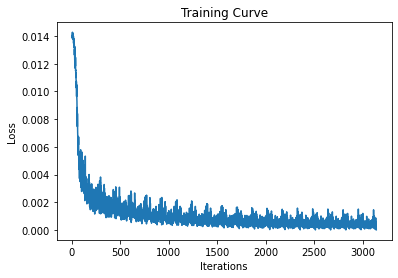

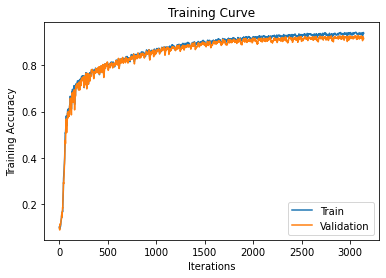

Final Training Accuracy: 0.9373
Final Validation Accuracy: 0.9145


In [ ]:
use_cuda = True

model = MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_mnist_ADAM_1(model, mnist_train, num_epochs=20) #p=1, optimizer = Adam 

The test accuracy on the held-out dataset is printed out below. 

In [ ]:
mnist_get_accuracy_test(model, train=False)#p=1, optimizer = Adam

0.8975

The codeblock below is run to train the model using the Adam optimizer and L2-SVM. The number of epochs may be changed to whichever value is suitable. 

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

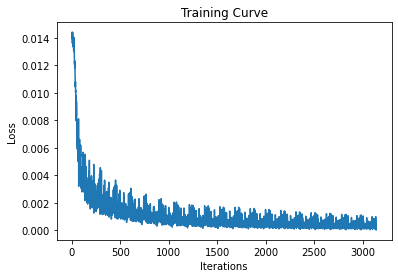

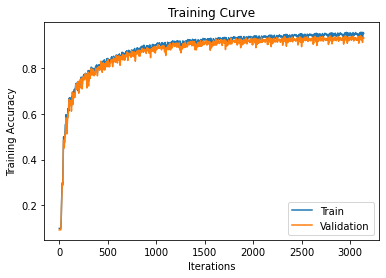

Final Training Accuracy: 0.9513
Final Validation Accuracy: 0.9305


In [ ]:

use_cuda = True

model = MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_mnist_ADAM_2(model, mnist_train, num_epochs=20) #p=2, optimizer = Adam 

The test accuracy on the held-out dataset is printed out below.

In [ ]:
mnist_get_accuracy_test(model, train=False) #p=2, optimizer = Adam 

0.907

The codeblock below is run to train the model using the SGD optimizer and L1-SVM. The number of epochs may be changed to whichever value is suitable.

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

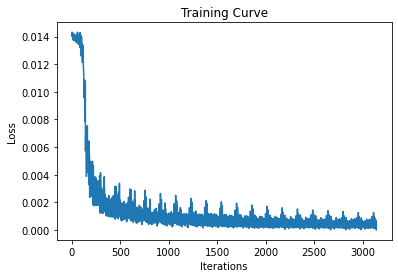

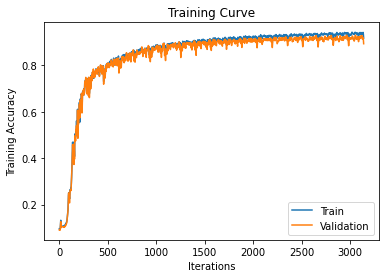

Final Training Accuracy: 0.9177
Final Validation Accuracy: 0.8935


In [ ]:
use_cuda = True

model = MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_mnist_SGD_1(model, mnist_train, num_epochs=20) #p=1, optimizer = SGD 

The test accuracy on the held-out dataset is printed out below.

In [ ]:
mnist_get_accuracy_test(model, train=False)  #p=1, optimizer = SGD 

0.876

The codeblock below is run to train the model using the SGD optimizer and L2-SVM. The number of epochs may be changed to whichever value is suitable.

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

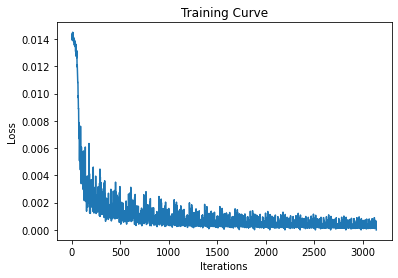

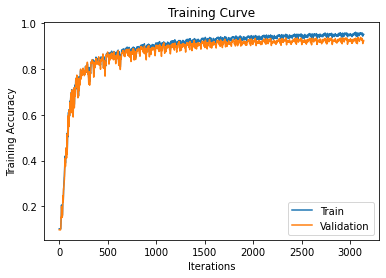

Final Training Accuracy: 0.9522
Final Validation Accuracy: 0.9255


In [ ]:
use_cuda = True

model = MNISTClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_mnist_SGD_2(model, mnist_train, num_epochs=20) #p=2, optimizer = SGD 

The test accuracy on the held-out dataset is printed out below.

In [ ]:
mnist_get_accuracy_test(model, train=False)  #p=2, optimizer = SGD 

0.9225

# The Fashion MNIST Dataset

##Loading and displaying The Fashion MNIST dataset

The following transformations, in addition to converting the images to tensors, are applied to the MNIST dataset when it is loaded frm the PyTorch libraries:

1.  Vertical Flip with a probability of 0.5
2.  Gaussian blur with a kernel size of 5

The dataset is then split into a train, validation and test datasets which are used to train and evaluate the model.


Finally, a random sample of the images are displayed with the transformations applied.


In [ ]:
# importing Fashion MNIST Data set (grey scale): https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
torch.manual_seed(1) # set the random seed
transform = transforms.Compose([transforms.GaussianBlur(kernel_size=5),
                                transforms.RandomVerticalFlip(), 
                                transforms.ToTensor()])
FashionMNIST_data = datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor())
FashionMNIST_data = list(FashionMNIST_data)
FashionMNIST_train = FashionMNIST_data[:10000]
FashionMNIST_val   = FashionMNIST_data[10000:12000]
FashionMNIST_test  = FashionMNIST_data[12000:14000]

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



##The Fashion MNIST CNN Model
The code block below is the architecture of the CNN used for the MNIST dataset. It consists of an _init_ method with the various layers of the CNN along with a _forward_ method that is what is used to build the architecture of the model. 

In [ ]:
class MNISTFashionClassifier(nn.Module): #net arch from https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582
# Build the neural network, expand on top of nn.Module
  def __init__(self):
    super(MNISTFashionClassifier, self).__init__()

    # define layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)

  # define forward function
  def forward(self, t):
    # conv 1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # conv 2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    # fc1
    t = t.reshape(-1, 12*4*4)
    t = self.fc1(t)
    t = F.relu(t)

    # fc2
    t = self.fc2(t)
    t = F.relu(t)

    # output
    t = self.out(t)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

The method below is used to get the accuracy of the model on the final held out test set.

In [ ]:
def fashionmnist_get_accuracy_test(model, train=False):
    if train:
        data = FashionMNIST_train
    else:
        data = FashionMNIST_test

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

The following codeblocks contain methods used to build and evaluate the various models implemented. Each method has been described below.



1. *get_accuracy*: used to get the accuracy on the train and validation datasets when training the model.
2. *train_MNIST_Adam_1*: used to train a CNN model that uses the Adam optimizer and L1-SVM. The training and validation accuracies are also plotted, along with the training loss. 
3. *train_MNIST_Adam_2*: used to train a CNN model that uses the Adam optimizer and L2-SVM. The training and validation accuracies are also plotted, along with the training loss. 
4. *train_MNIST_SGD_1*: used to train a CNN model that uses the Stochastic Gradient Descent (SGD) optimizer and L1-SVM. The training and validation accuracies are also plotted, along with the training loss. 
5. *train_MNIST_SGD_2*: used to train a CNN model that uses the Stochastic Gradient Descent (SGD) optimizer and L2-SVM. The training and validation accuracies are also plotted, along with the training loss. 

In [ ]:
def MNISTFashion_get_accuracy(model, train=False):
    if train:
        data = FashionMNIST_train
    else:
        data = FashionMNIST_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


def train_MNISTFashion_SGD_1(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(MNISTFashion_get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(MNISTFashion_get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


def train_MNISTFashion_SGD_2(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=2)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(MNISTFashion_get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(MNISTFashion_get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def train_MNISTFashion_ADAM_1(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(MNISTFashion_get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(MNISTFashion_get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


def train_MNISTFashion_ADAM_2(model, data, batch_size=64, num_epochs=1):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.MultiMarginLoss(p=2)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    #optimizer = optim.Adam(model.parameters())
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            #loss = F.nll_loss(out,labels)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(MNISTFashion_get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(MNISTFashion_get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

The codeblock below is run to train the model using the SGD optimizer and L1-SVM. The number of epochs may be changed to whichever value is suitable.

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

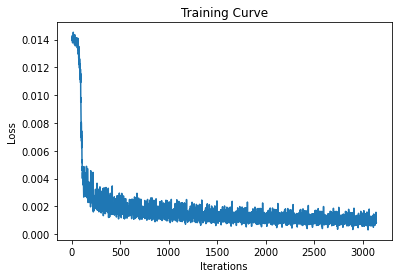

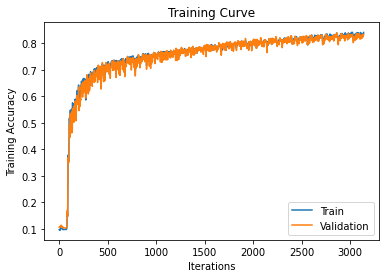

Final Training Accuracy: 0.8405
Final Validation Accuracy: 0.833


In [ ]:
use_cuda = True

model = MNISTFashionClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_MNISTFashion_SGD_1(model, FashionMNIST_train, num_epochs=20) #p=1, optimizer = sgd

The test accuracy on the held-out dataset is printed below.

In [ ]:
fashionmnist_get_accuracy_test(model, train=False) #p=1, optimizer = sgd

0.8185

The codeblock below is run to train the model using the SGD optimizer and L2-SVM. The number of epochs may be changed to whichever value is suitable.

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

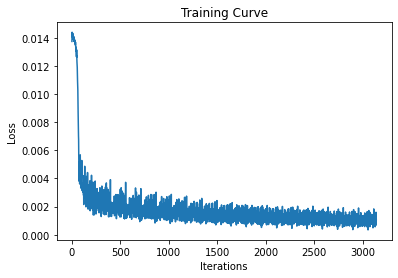

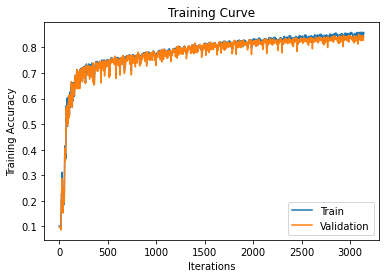

Final Training Accuracy: 0.854
Final Validation Accuracy: 0.8385


In [ ]:
use_cuda = True

model = MNISTFashionClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_MNISTFashion_SGD_2(model, FashionMNIST_train, num_epochs=20) #p=2, optimizer = sgd

The test accuracy on the held-out dataset is printed below.

In [ ]:
fashionmnist_get_accuracy_test(model, train=False) #p=2, optimizer = sgd

0.8335

The codeblock below is run to train the model using the Adam optimizer and L1-SVM. The number of epochs may be changed to whichever value is suitable.

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

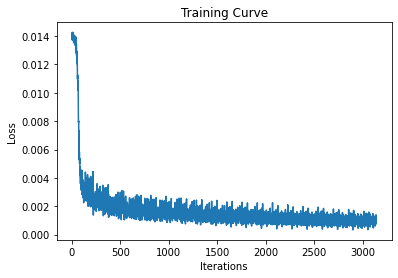

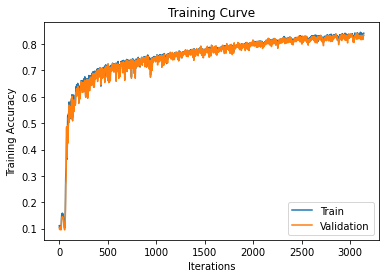

Final Training Accuracy: 0.8417
Final Validation Accuracy: 0.834


In [ ]:
use_cuda = True

model = MNISTFashionClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_MNISTFashion_ADAM_1(model, FashionMNIST_train, num_epochs=20) #p=1, optimizer = ADAM

The test accuracy on the held-out dataset is printed below.

In [ ]:
fashionmnist_get_accuracy_test(model, train=False) #p=1, optimizer = ADAM

0.8245

The codeblock below is run to train the model using the Adam optimizer and L2-SVM. The number of epochs may be changed to whichever value is suitable.

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [64].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  return torch._C._nn.multi_margin_loss(input, target, p, margin, weight, reduction_enum)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3349: UserWarning: An output with one or more elements was resized since it had shape [64], which does not match the required output shape [].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.re

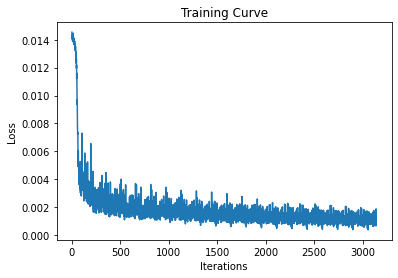

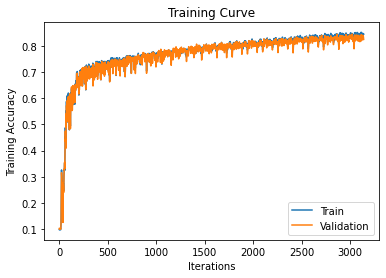

Final Training Accuracy: 0.844
Final Validation Accuracy: 0.8245


In [ ]:
use_cuda = True

model = MNISTFashionClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train_MNISTFashion_ADAM_2(model, FashionMNIST_train, num_epochs=20) #p=2, optimizer = ADAM

The test accuracy on the held-out dataset is printed below.

In [ ]:
fashionmnist_get_accuracy_test(model, train=False) #p=2, optimizer = ADAM

0.825